In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Examen 1
Eduardo Patrón Anchondo, PINNs

In [ ]:
N = np.array([0, 1, 2, 3, 4])
K = np.array([120, 110, 130, 125, 140]) # Capacidad de carga en número de individuos.

## 1) Interpolaciones de K

In [ ]:
from scipy.interpolate import CubicSpline

spline = CubicSpline(N, K)

t = np.linspace(0, 4, 100)
yS = spline(t)

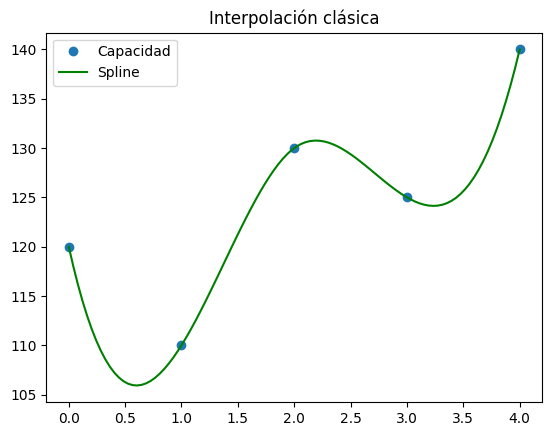

In [ ]:
plt.plot(N, K, 'o', label = 'Capacidad')
plt.plot(t, yS, 'g', label = 'Spline')

plt.title('Interpolación clásica')
plt.legend()
plt.show()

In [ ]:
## Interpolación por NN

# Red neuronal simple
class SimpleMLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden1 = nn.Linear(1,4)
    self.hidden2 = nn.Linear(4,4)
    # self.hidden3 = nn.Linear(4,4)
    self.output = nn.Linear(4,1)

  def forward(self, x):
    x = torch.sigmoid(self.hidden1(x))
    x = torch.sigmoid(self.hidden2(x))
    # x = torch.sigmoid(self.hidden3(x))
    return self.output(x)

def train_model(x_tensor, y_tensor, epochs = 1000, lr = 0.01):
  # Definir modelo, pérdida y optimizador
  model = SimpleMLP()
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  losses = []

  # Iteraciones de epocas
  for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(x_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch == epochs - 1:
      print(f"Epoch {epoch}: Final loss = {loss.item():.6f}")

  return model, losses

In [ ]:
N_tensor = torch.tensor(N.reshape(-1,1), dtype = torch.float32)
K_tensor = torch.tensor(K.reshape(-1,1), dtype = torch.float32)

model, losses = train_model(N_tensor, K_tensor, epochs = 4000, lr = 0.05)

Epoch 3999: Final loss = 3.057813


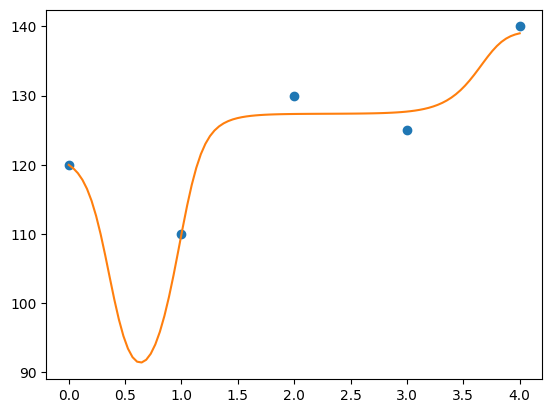

In [ ]:
t_tensor = torch.tensor(t.reshape(-1,1), dtype = torch.float32)
K_pred = model(t_tensor).detach().numpy()

plt.plot(N, K, 'o', label = 'Capacidad')
plt.plot(t, K_pred, label = 'DNN')

plt.show()

Para evitar un sobre ajuste de la DNN hay varias formas, las cuales burdamente consisten en tener un modelo simple con un entrenemineto suficiente. Concretamente, esto es mantener una cantidad de neuronas pequeña, con una tasa de aprendizaje baja y una cantidad de épocas suficiente.

Los hiperparámetros tomados no hace claro el hecho de esto, ya que se tomaron 4000 épocas y una tasa de aprendizaje media. Sim embargo, esto se hizo por se noto que la red se demoraba mucho en converger. Se hicieron varios experimentos hasta encontrar una consistencia decente

## 2) Datos sintetizados

In [ ]:
r = 0.5 # Tasa intrínseca de crecimiento

h = 0.5 # Tamaño de paso

n = int((N[-1] - N[0]) / h) +1 # Extra

grid = np.linspace(N[0], N[-1], n)

Dado que los datos conocidos para $K(t)$ no son suficientes para el tamaño de paso $h = 0.5$ algo que se puede hacer para obtener los puntos es conciderar la evaluación de dichos puntos in los interpoladores: Cubic Splines y DNN. Los datos correspondientes son:

In [ ]:
# Datos Splines
Ks = spline(grid)
# Datos DNNs
Kd = model(torch.tensor(grid.reshape(-1,1), dtype = torch.float32)).detach().numpy()

## 3) Aproximación de $P(t)$ por métodos numéricos

In [ ]:
# Método de Euler
def euler(f, t0, y0, t, K, h):
    N = np.size(t) - 1
    y = np.zeros(N+1)
    y[0] = y0
    for n in range(N):
        k1 = f(t[n], y[n], K[n])
        y[n+1] = y[n] + h * k1
    return y

# Método de Heun
def heun(f, t0, y0, t, K, h):
    N = np.size(t) - 1
    y = np.zeros(N+1)
    y[0] = y0
    for n in range(N):
        k1 = f(t[n], y[n], K[n])
        k2 = f(t[n] + h, y[n] + h*k1, K[n])
        y[n+1] = y[n] + (h/2) * (k1 + k2)
    return y

# Método del punto medio
def midpoint(f, t0, y0, t, K, h):
    N = np.size(t) - 1
    y = np.zeros(N + 1)
    y[0] = y0
    for n in range(N):
        k1 = f(t[n], y[n], K[n])
        k2 = f(t[n] + h/2, y[n] + h/2 * k1, K[n])
        y[n+1] = y[n] + h * k2
    return y

In [ ]:
def f(t, P, K, r = 0.5):
  return r*P*(1 - P/K)

In [ ]:
# Condición inicial
t0, P0 = 0, 50

# Soluciones de los métodos numéricos

# Base Splines
P_eulerS = euler(f, t0, P0, grid, Ks, h)
P_heunS = heun(f, t0, P0, grid, Ks, h)
P_mpS = midpoint(f, t0, P0, grid, Ks, h)

# Base DNNs
P_eulerD = euler(f, t0, P0, grid, Kd, h)
P_heunD = heun(f, t0, P0, grid, Kd, h)
P_mpD = midpoint(f, t0, P0, grid, Kd, h)

/tmp/ipython-input-1525970732.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n+1] = y[n] + h * k1
/tmp/ipython-input-1525970732.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n+1] = y[n] + (h/2) * (k1 + k2)
/tmp/ipython-input-1525970732.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n+1] = y[n] + h * k2


## 4) Comparación de los resultados

In [ ]:
import pandas as pd

interClasica = pd.DataFrame({
        "Malla": grid,
        "Euler Spline": P_eulerS,
        "Heun Spline": P_heunS,
        "PM Spline": P_mpS,
        "Euler DNN": P_eulerD,
        "Heun DNN": P_heunD,
        "PM DNN": P_mpD,
        })

display(interClasica)

,Malla,Euler Spline,Heun Spline,PM Spline,Euler DNN,Heun DNN,PM DNN
0,0.0,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
1,0.5,57.291667,57.388193,57.415885,57.291706,57.388238,57.415930
2,1.0,63.891442,63.868656,63.920978,62.932006,62.830329,62.877172
3,1.5,70.586765,70.378975,70.453921,69.664653,69.395242,69.465521
4,2.0,77.960278,77.556296,77.655249,77.510093,77.093362,77.191306
5,2.5,85.762261,85.130404,85.252637,85.094171,84.442625,84.562498
6,3.0,92.989947,92.070079,92.206952,92.159086,91.221973,91.355716
7,3.5,98.943173,97.738422,97.876854,98.571613,97.346020,97.485325
8,4.0,104.196874,102.756212,102.889955,104.698130,103.206300,103.346946


En la tabla superior se presenta en la primera columna los tiempos $t_n$ para los cuales se determino la aproximación de $P(t)$, las cuales estan el las columnas siguientes.

La malla cuenta con dos tipos de datos de entreda para la función $K$, lo cual genera variaciones en el resultado. Por lo que podemos dividir los resultados en categoria Spline y DNN (lo que esta específicado en la columna). La diferencias más clara de estos modelos, es que para los tiempos $t_n$ que son completamente de interpolación, es cuando los resultados de $P$ difieren más (a ojo como una unidad) , mientras que para los tiempos con datos conocidos de $K$ la diferencia es menor.

## 5)

In [ ]:
r = 0.5 # Tasa intrínseca de crecimiento

h = 0.1 # Tamaño de paso

n = int((N[-1] - N[0]) / h) +1 # Extra

grid = np.linspace(N[0], N[-1], n)

# Datos Splines
Ks = spline(grid)
# Datos DNNs
Kd = model(torch.tensor(grid.reshape(-1,1), dtype = torch.float32)).detach().numpy()

In [ ]:
# Condición inicial
t0, P0 = 0, 50

# Soluciones de los métodos numéricos

# Base Splines
P_eulerS = euler(f, t0, P0, grid, Ks, h)
P_heunS = heun(f, t0, P0, grid, Ks, h)
P_mpS = midpoint(f, t0, P0, grid, Ks, h)

# Base DNNs
P_eulerD = euler(f, t0, P0, grid, Kd, h)
P_heunD = heun(f, t0, P0, grid, Kd, h)
P_mpD = midpoint(f, t0, P0, grid, Kd, h)

/tmp/ipython-input-1525970732.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n+1] = y[n] + h * k1
/tmp/ipython-input-1525970732.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n+1] = y[n] + (h/2) * (k1 + k2)
/tmp/ipython-input-1525970732.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n+1] = y[n] + h * k2


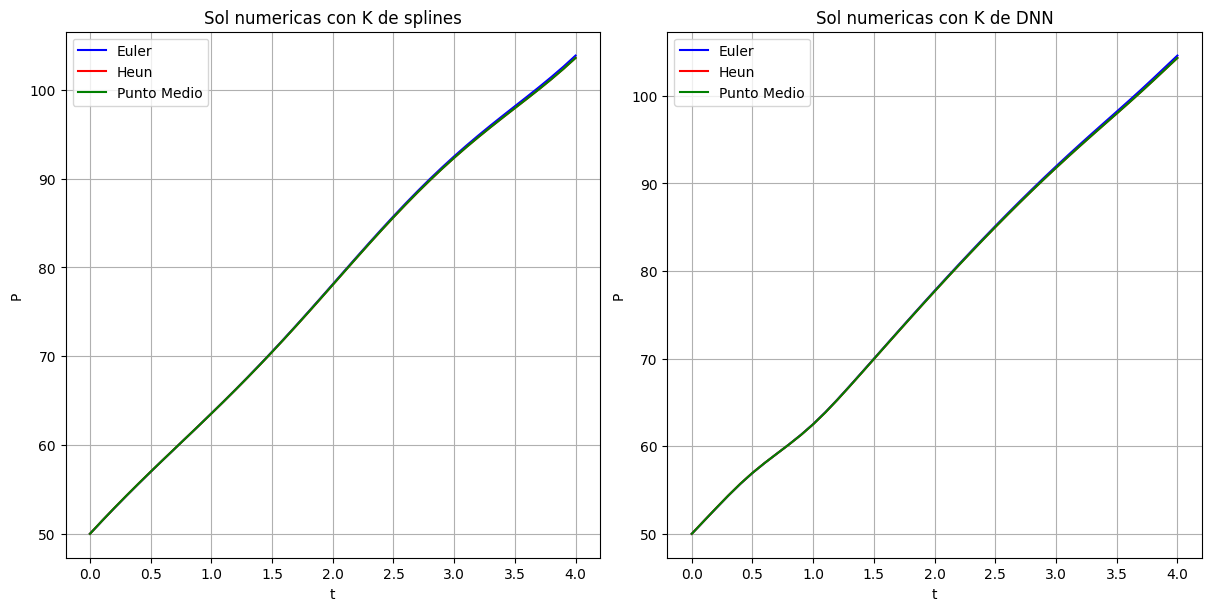

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 6), layout='constrained')

ax[0].plot(grid, P_eulerS, 'b', label = 'Euler')
ax[0].plot(grid, P_heunS, 'r', label = 'Heun')
ax[0].plot(grid, P_mpS, 'g', label = 'Punto Medio')

ax[0].set_title('Sol numericas con K de splines')
ax[0].grid(True)
ax[0].set_xlabel('t')
ax[0].set_ylabel('P')
ax[0].legend()

ax[1].plot(grid, P_eulerD, 'b', label = 'Euler')
ax[1].plot(grid, P_heunD, 'r', label = 'Heun')
ax[1].plot(grid, P_mpD, 'g', label = 'Punto Medio')

ax[1].set_title('Sol numericas con K de DNN')
ax[1].grid(True)
ax[1].set_xlabel('t')
ax[1].set_ylabel('P')
ax[1].legend()

En primera instancia las discrepancias con entre los datos de la tabla y las gráficas no es tan notoria. Lo que resalta más es que para la aproximaciónde $P(4)$ los valores de las gráficas aparentan ser más cercanos. Por lo tanto, considerando que se tuvieron que sintetizar más datos de $K$ para evaluar. Se podría considerar que el tamaño de paso $h=0.5$ es mejor, ya que aparenta ser suficiente para capturar el comportamiento del sistema, implica sintetizar menos datos y, al tener una malla más pequeña, una menor capacidad de computo.